<a href="https://colab.research.google.com/github/LunarianLuvien/Ai_term_project/blob/main/TermProject_05210000905_05210000249.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

# List for dataframe
data_list = []

# Traverse XML files transferred from drive to colab
for root_dir, dirs, files in os.walk('/content/annotations'):
    for file in files:
        # Process XML files
        if file.endswith('.xml'):

            tree = ET.parse(os.path.join(root_dir, file))

            # Retrieve data from XML file and write to CSV columns
            root = tree.getroot()
            filename = root.find('filename').text
            for obj in root.findall('object'):
                bndbox = obj.find('bndbox')
                xmin = bndbox.find('xmin').text
                ymin = bndbox.find('ymin').text
                xmax = bndbox.find('xmax').text
                ymax = bndbox.find('ymax').text

                # Add information to datalist
                data_list.append([filename, xmin, xmax, ymin, ymax])

# Convert list to dataframe for easier processing
df = pd.DataFrame(data_list, columns=["filename", "xmin", "xmax", "ymin", "ymax"])

df.to_csv('labels.csv', index=False)




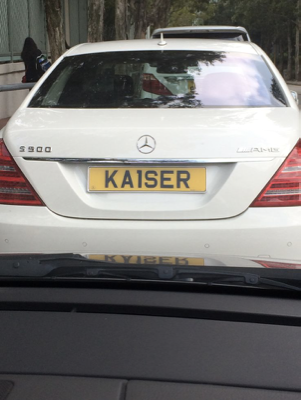

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

df = pd.read_csv('labels.csv')  # Read CSV file
import xml.etree.ElementTree as xet
filename = df['filename'][0]  # First file

def getFileName(filename):    # XMLs are in colab, images are pulled from drive
    filepath_image = os.path.join('/content/drive/MyDrive/images', filename)
    return filepath_image

getFileName(filename) # Get file location from the image folder
image_path = list(df['filename'].apply(getFileName))

# Check if images are correctly fetched from the image folder.
file_path = image_path[0]
from google.colab.patches import cv2_imshow
img = cv2.imread(file_path)

cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
# Get car values from the first row of the CSV file
first_image_xmin, first_image_xmax, first_image_ymin, first_image_ymax = df.iloc[0, 1:].values



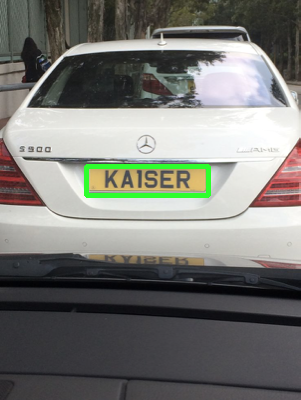

In [ ]:
rectangle_color = (45, 255, 45)  # Green color code
rectangle_thickness = 3
# Create a rectangle with box data from the file to verify the image and box data match correctly in the CSV
cv2.rectangle(img, (first_image_xmin, first_image_ymin), (first_image_xmax, first_image_ymax), rectangle_color, rectangle_thickness)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
# Prepare data before training (e.g. normalization)
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [ ]:
labels = df.iloc[:,1:].values # First column is image names, other columns are box labels


In [ ]:
data = [] # Image data
output = [] # Output labels
for ind in range(len(image_path)):  # Repeat for all images
  img = image_path[ind]
  img_arr = cv2.imread(img) # Read image from path
  h, w, d = img_arr.shape # Height, width, depth of image

  load_image = load_img(img, target_size=(224, 224)) # Load image at 224x224 size
                                                     # Models perform better at this size
  load_image_arr = img_to_array(load_image)
  normal_load_image_arr = load_image_arr / 255.0 # Normalization

  # Normalize the box boundaries (labels)
  xmin, xmax, ymin, ymax = labels[ind]
  nr_xmin = xmin / w
  nr_xmax = xmax / w

  nr_ymin = ymin / h
  nr_ymax = ymax / h

  label_norm = (nr_xmin, nr_xmax, nr_ymin, nr_ymax) # Normalized output
  data.append(normal_load_image_arr)
  output.append(label_norm)


In [ ]:
x = np.array(data, dtype=np.float32)
y = np.array(output, dtype=np.float32)

In [ ]:
# Split dataset into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=0)


In [ ]:
# Import libraries for deep learning models
from tensorflow.keras.applications import MobileNetV2, InceptionV3, InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model
import tensorflow as tf


In [ ]:
inception_resnet = InceptionResNetV2(weights='imagenet', include_top=False,
                                     input_tensor=Input(shape=(224,224, 3)))
# We use InceptionResNetV2 with preloaded ImageNet weights

inception_resnet.trainable = False # ImageNet weights will not be altered
# Configure model layers
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500, activation="relu")(headmodel)
headmodel = Dense(250, activation="relu")(headmodel)
headmodel = Dense(4, activation='sigmoid')(headmodel) # Output layer


219055592/219055592 [==============================] - 1s 0us/step


In [ ]:
# Compile the model and print the summary for checking
model = Model(inception_resnet.input, outputs=headmodel)
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
tfb = TensorBoard('object_detection')

In [ ]:
# Train the model for 100 epochs with specified parameters
history = model.fit(x=x_train, y=y_train, batch_size=10, epochs=100,
                    validation_data=(x_test, y_test), callbacks=[tfb])


Epoch 1/100
38/38 [==============================] - 26s 137ms/step - loss: 0.1771 - val_loss: 0.1725
Epoch 2/100
38/38 [==============================] - 1s 27ms/step - loss: 0.1547 - val_loss: 0.1478
Epoch 3/100
38/38 [==============================] - 1s 27ms/step - loss: 0.1205 - val_loss: 0.0847
Epoch 4/100
38/38 [==============================] - 1s 27ms/step - loss: 0.0377 - val_loss: 0.0295
Epoch 5/100
38/38 [==============================] - 1s 27ms/step - loss: 0.0185 - val_loss: 0.0296
Epoch 6/100
38/38 [==============================] - 1s 28ms/step - loss: 0.0169 - val_loss: 0.0237
Epoch 7/100
38/38 [==============================] - 1s 27ms/step - loss: 0.0125 - val_loss: 0.0205
Epoch 8/100
38/38 [==============================] - 1s 27ms/step - loss: 0.0115 - val_loss: 0.0243
Epoch 9/100
38/38 [==============================] - 1s 29ms/step - loss: 0.0117 - val_loss: 0.0223
Epoch 10/100
38/38 [==============================] - 1s 28ms/step - loss: 0.0093 - val_loss: 0.02

In [ ]:
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=300,
                    validation_data=(x_test,y_test),callbacks=[tfb],initial_epoch=101)

Epoch 102/300
38/38 [==============================] - 1s 29ms/step - loss: 0.0066 - val_loss: 0.0192
Epoch 103/300
38/38 [==============================] - 1s 29ms/step - loss: 0.0067 - val_loss: 0.0196
Epoch 104/300
38/38 [==============================] - 1s 28ms/step - loss: 0.0067 - val_loss: 0.0194
Epoch 105/300
38/38 [==============================] - 1s 28ms/step - loss: 0.0067 - val_loss: 0.0204
Epoch 106/300
38/38 [==============================] - 1s 26ms/step - loss: 0.0070 - val_loss: 0.0217
Epoch 107/300
38/38 [==============================] - 1s 27ms/step - loss: 0.0072 - val_loss: 0.0191
Epoch 108/300
38/38 [==============================] - 1s 25ms/step - loss: 0.0070 - val_loss: 0.0211
Epoch 109/300
38/38 [==============================] - 1s 25ms/step - loss: 0.0070 - val_loss: 0.0188
Epoch 110/300
38/38 [==============================] - 1s 26ms/step - loss: 0.0067 - val_loss: 0.0201
Epoch 111/300
38/38 [==============================] - 1s 26ms/step - loss: 0.0066

In [ ]:
model.save('/content/gdrive/My Drive/300epok_model.h5')

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/300epok_model.h5')
print("Üstte eğitilen model drive'dan yüklendi.")

Üstte eğitilen model drive'dan yüklendi.


In [ ]:
test_path = '/content/drive/MyDrive/denemeAraba.jpeg'
image = load_img(test_path) # original image
image = np.array(image, dtype=np.uint8)
image1 = load_img(test_path,target_size=(224,224)) # turn image into wanted target size
image_arr_224 = img_to_array(image1)/255.0 # normalized image array

In [ ]:
# original image size
h, w, d = image.shape
print('Height: ', h, ' and width: ', w)

Height:  998  and width:  1200


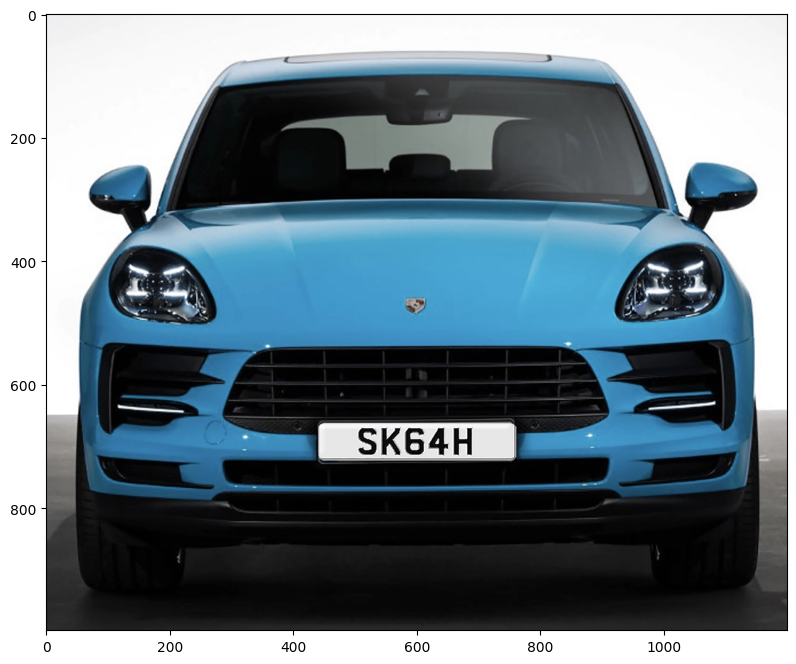

In [ ]:
plt.figure(figsize=(10,8))
plt.imshow(image)
plt.show()


In [ ]:
image_arr_224.shape

(224, 224, 3)

In [ ]:
test_arr = image_arr_224.reshape(1,224,224,3) # increase the dimension
                                            # 1 represent the number of image that we pass model

In [ ]:
#prediction
coordinate_box = model.predict(test_arr)
coordinate_box

1/1 [==============================] - 0s 41ms/step


array([[0.35522807, 0.6454187 , 0.6474921 , 0.74942154]], dtype=float32)

In [ ]:
# Denormalize to locate the box in the original image
denormalize = np.array([w, w, h, h])
coordinate_box = coordinate_box * denormalize
coordinate_box


array([[426.27367973, 774.50244427, 646.19712651, 747.92269385]])

In [ ]:
coordinate_box = coordinate_box.astype(np.int32) # Convert float values to integer
coordinate_box


array([[426, 774, 646, 747]], dtype=int32)

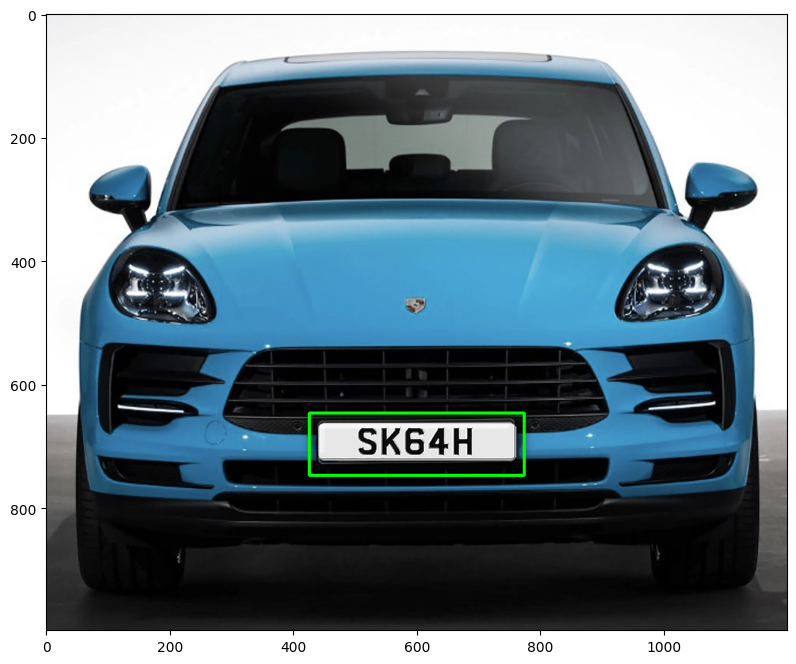

In [ ]:
xmin,xmax,ymin,ymax = coordinate_box[0]
pt1 =(xmin,ymin)
pt2=(xmax,ymax)
cv2.rectangle(image,pt1,pt2,(0,255,0), 3)
plt.figure(figsize=(10,8))
plt.imshow(image)
plt.show()

In [ ]:

img = np.array(load_img(test_path))
# Extract region of interest (ROI) from the image using coordinates
roi = img[ymin:ymax, xmin:xmax]


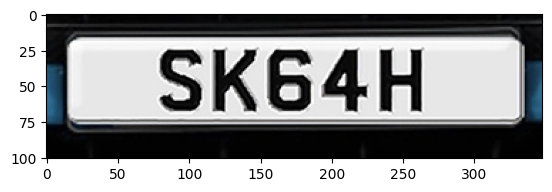

In [ ]:
plt.imshow(roi)
plt.show()

In [ ]:

black_image_deneme = np.zeros((h, w, 3), dtype=np.uint8) # Create a black image with the same size as the main image
white_layer = np.ones((ymax - ymin, xmax - xmin, 3), dtype=np.uint8) * 255
black_image_deneme[ymin:ymax, xmin:xmax] = white_layer # Place white rectangle at the ROI


<function matplotlib.pyplot.show(close=None, block=None)>

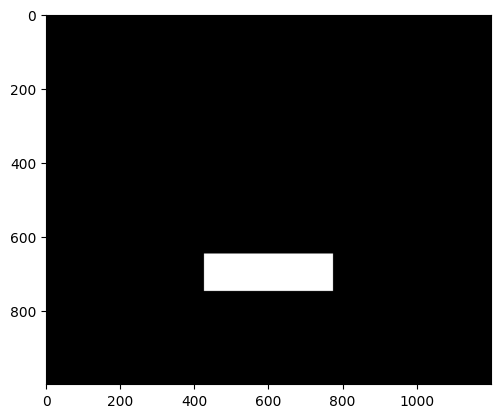

In [ ]:
plt.imshow(black_image_deneme)
plt.show

In [ ]:
cv2.imwrite('/content/drive/MyDrive/siyah_plaka_deneme.png', black_image_deneme)

True

In [ ]:
cv2.imwrite('siyah_plaka.png', black_image_deneme)

True

In [ ]:
%cd /content/drive/MyDrive



/content/drive/MyDrive


In [ ]:
!git clone https://github.com/advimman/lama.git. # github repository copy

Cloning into 'lama'...
remote: Enumerating objects: 399, done.
remote: Counting objects: 100% (399/399), done.
remote: Compressing objects: 100% (262/262), done.
remote: Total 399 (delta 142), reused 273 (delta 118), pack-reused 0
Receiving objects: 100% (399/399), 6.52 MiB | 10.05 MiB/s, done.
Resolving deltas: 100% (142/142), done.
Updating files: 100% (212/212), done.


In [ ]:
# Downloading necessary libraries
!virtualenv inpenv --python=/usr/bin/python3
!source inpenv/bin/activate
!pip install torch==1.8.0 torchvision==0.9.0

%cd lama
!pip install -r requirements.txt

/bin/bash: virtualenv: command not found
/bin/bash: inpenv/bin/activate: No such file or directory
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement torch==1.8.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1)
ERROR: No matching distribution found for torch==1.8.0
[Errno 2] No such file or directory: 'lama'
/content/drive/MyDrive/lama
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.8/29.8 MB 52.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 103.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/7

In [ ]:
%cd /content/drive/MyDrive/lama

/content/drive/MyDrive/lama


In [ ]:
!export TORCH_HOME=$(pwd) && export PYTHONPATH=$(pwd)

In [ ]:
!pip3 install wldhx.yadisk-direct

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!curl -L $(yadisk-direct https://disk.yandex.ru/d/ouP6l8VJ0HpMZg) -o big-lama.zip
!unzip big-lama.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  363M    0  363M    0     0  7048k      0 --:--:--  0:00:52 --:--:-- 7684k
Archive:  big-lama.zip
  inflating: big-lama/config.yaml    
  inflating: big-lama/models/best.ckpt  


In [ ]:
!curl -L $(yadisk-direct https://disk.yandex.ru/d/EgqaSnLohjuzAg) -o lama-models.zip
!unzip lama-models.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 6257M    0 6257M    0     0   9.9M      0 --:--:--  0:10:29 --:--:--  9.9M
Archive:  lama-models.zip
  inflating: LaMa_models/big-lama-with-discr/config.yaml  
  inflating: LaMa_models/big-lama-with-discr/models/best.ckpt  
  inflating: LaMa_models/big-lama/config.yaml  
  inflating: LaMa_models/big-lama/models/best.ckpt  
  inflating: LaMa_models/lama-celeba-hq-pl-abl/lama-no-pl/config.yaml  
  inflating: LaMa_models/lama-celeba-hq-pl-abl/lama-no-pl/models/best.ckpt  
  inflating: LaMa_models/lama-celeba-hq/ lama-regular/config.yaml  
  inflating: LaMa_models/lama-celeba-hq/ lama-regular/models/best.ckpt  
  inflating: LaMa_models/lama-celeba-hq/lama-deep/config.yaml  
  inflating: LaMa_models/lama-celeba-hq/lama-deep/models/best.ckpt  
  inflating

In [ ]:
!curl -L $(yadisk-direct https://disk.yandex.ru/d/xKQJZeVRk5vLlQ) -o LaMa_test_images.zip
!unzip LaMa_test_images.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  118M    0  118M    0     0  6857k      0 --:--:--  0:00:17 --:--:-- 10.3M
Archive:  LaMa_test_images.zip
  inflating: LaMa_test_images/000068.png  
  inflating: LaMa_test_images/000068_mask.png  
  inflating: LaMa_test_images/000814.png  
  inflating: LaMa_test_images/000814_mask.png  
  inflating: LaMa_test_images/1010698.png  
  inflating: LaMa_test_images/1010698_mask.png  
  inflating: LaMa_test_images/15355245546_d2a4634b16_o.png  
  inflating: LaMa_test_images/15355245546_d2a4634b16_o_mask.png  
  inflating: LaMa_test_images/16693_1.png  
  inflating: LaMa_test_images/16693_12.png  
  inflating: LaMa_test_images/16693_12_mask.png  
  inflating: LaMa_test_images/16693_1_mask.png  
  inflating: LaMa_test_images/51042170913_78f61a87af_o.png  
  

In [ ]:
!cp -r /content/drive/MyDrive/lama/saicinpainting /content/drive/MyDrive/lama/bin

In [ ]:
!cp -r /content/drive/MyDrive/lama/models /content/drive/MyDrive/lama/bin

In [ ]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install kornia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.4/653.4 kB 9.6 MB/s eta 0:00:00


In [ ]:
!pip install hydra-core

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=16a4c08954e4c5822bb46cdb42c8fb25d440e4281e44cafaa7f906f54111a458
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


In [ ]:
!pip install webdataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached webdataset-0.2.48-py3-none-any.whl (51 kB)
  Using cached braceexpand-0.1.7-py2.py3-none-any.whl (5.9 kB)


In [ ]:
!python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/LaMa_test_images outdir=$(pwd)/output


Detectron v2 is not installed
/content/drive/MyDrive/lama/bin/predict.py:38: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='../configs/prediction', config_name='default.yaml')
/usr/local/lib/python3.10/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
  ret = run_job(
[2023-06-06 17:25:57,559][saicinpainting.utils][WARNING] - Setting signal 10 handler <function print_traceback_handler at 0x7f7dd44a9090>
[2023-06-06 17:25:57,857][root][INFO] - Make training model default
[2023-06-06 17:25:57,858][saicinpainting.training.trainers.base][INFO] - BaseInpaintingTrainingModule init called
[2023-06-06 17:25:57,858][root][INFO] - Make generator ffc_resnet
[2023-06-06 17:25:

In [ ]:
!python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/LaMa_test_images outdir=$(pwd)/output

Detectron v2 is not installed
/content/drive/MyDrive/lama/bin/predict.py:38: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='../configs/prediction', config_name='default.yaml')
/usr/local/lib/python3.10/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
  ret = run_job(
[2023-06-06 17:53:14,577][saicinpainting.utils][WARNING] - Setting signal 10 handler <function print_traceback_handler at 0x7fae3f9f5090>
[2023-06-06 17:53:14,611][root][INFO] - Make training model default
[2023-06-06 17:53:14,611][saicinpainting.training.trainers.base][INFO] - BaseInpaintingTrainingModule init called
[2023-06-06 17:53:14,612][root][INFO] - Make generator ffc_resnet
[2023-06-06 17:53:

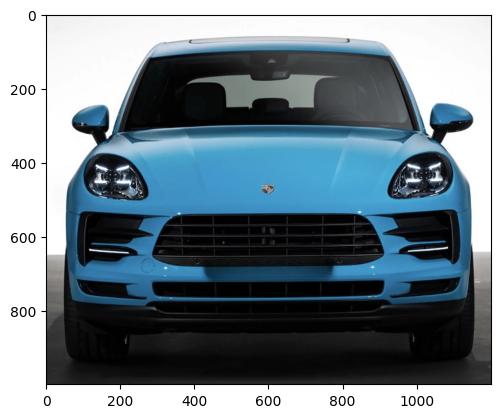

In [ ]:
# Display the image after removing the license plate using laMa-cleaner
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open('/content/drive/MyDrive/lama/output/deneme2_mask.png')
plt.imshow(img)
plt.show()
